In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt

In [2]:
def sphere(individuo):
    resultado = 0
    for i in individuo:
        resultado += i ** 2
    return resultado
    
def rastrigin(individuo):
    resultado = 0
    for i in individuo:
        numero = 2*3.1415*i
        p = (numero/180)*math.pi
        resultado+= (i**2) - (10 * math.cos(p)) + 10    
    return resultado
    
def rosenbrock(individuo):
    resultado = 0
    for i in range(0,(len(individuo)-1)):
        resultado += 100*(individuo[i+1] - individuo[i]**2)**2 + (individuo[i] - 1)**2   
    return resultado

## Algoritmo ABC

In [3]:
class FonteAlimentacao:
    def __init__(self, dimensoes:int, limite_min: float, limite_max: float, fator_abandono:int, funcao_fitness):
        self.dimensoes = dimensoes
        self.limite_min = limite_min
        self.limite_max = limite_max
        self.funcao_fitness = funcao_fitness

        self.posicao = np.random.uniform(limite_min, limite_max, dimensoes)
        self.fator_abandono = fator_abandono

        self.fitness = funcao_fitness(self.posicao)
        self.tentativas = 0
    
    def calcular_fitness(self):
        self.fitness = self.funcao_fitness(self.posicao) 

class Abelha:
    def __init__(self, dimensoes:int, limite_min: float, limite_max: float, funcao_fitness, fonte = None):
        self.dimensoes = dimensoes
        self.limite_min = limite_min
        self.limite_max = limite_max
        self.funcao_fitness = funcao_fitness

        if fonte is not None:
            self.posicao = np.copy(fonte.posicao)
            self.fonte = fonte
            self.fitness = funcao_fitness(self.posicao)
        else:
            self.posicao = None
            self.fonte = None
            self.fitness = 0

    def calcular_posicao(self, fontes):
        indice_dimensao = random.randint(0, self.dimensoes - 1)
        indice_fonte = random.randint(0, len(fontes) - 1)
        while fontes[indice_fonte] == self.fonte:
            indice_fonte = random.randint(0, len(fontes) - 1)

        fator_aleatorio = random.uniform(-1, 1)
        nova_posicao = self.fonte.posicao[indice_dimensao] + fator_aleatorio * (
            self.fonte.posicao[indice_dimensao] - fontes[indice_fonte].posicao[indice_dimensao])
        
        nova_posicao = np.clip(nova_posicao, self.limite_min, self.limite_max)
        self.posicao[indice_dimensao] = nova_posicao

    def calcular_fitness(self):
        self.fitness = self.funcao_fitness(self.posicao) 

class AlgoritmoABC:
    def __init__(self, dimensoes:int, limite_min: float, limite_max: float, tamanho_populacao:int, fator_abandono:int, ciclos:int, funcao_fitness):
        self.dimensoes = dimensoes
        self.limite_min = limite_min
        self.limite_max = limite_max

        self.tamanho_populacao = tamanho_populacao
        self.fator_abandono = fator_abandono
        self.ciclos = ciclos
        self.funcao_fitness = funcao_fitness

        self.melhor_posicao = None
        self.melhor_fitness = float('inf')
        self.ciclo_best = 0

    def gerar_fontes(self):
        return [FonteAlimentacao(self.dimensoes, self.limite_min, self.limite_max, self.fator_abandono, self.funcao_fitness) 
                for _ in range(int(self.tamanho_populacao/2))]
    
    def gerar_abelhas_empregadas(self, fontes):
        return [Abelha(self.dimensoes, self.limite_min, self.limite_max, self.funcao_fitness, fonte=fonte) for fonte in fontes]
    
    def gerar_abelhas_observadoras(self):
        return [Abelha(dimensoes=self.dimensoes, limite_min=self.limite_min, limite_max=self.limite_max, funcao_fitness=self.funcao_fitness) 
                for _ in range(int(self.tamanho_populacao/2)) ]

    def executar_abelhas_empregadas(self, abelhas_empregadas, fontes):
        for abelha in abelhas_empregadas:
            abelha.calcular_posicao(fontes)
            abelha.calcular_fitness()
            fonte_abelha = abelha.fonte
            
            if abelha.fitness < fonte_abelha.fitness:
                fonte_abelha.posicao = np.copy(abelha.posicao)
                fonte_abelha.calcular_fitness()
                fonte_abelha.tentativas = 0
            else:
                fonte_abelha.tentativas += 1

    def selecionar_fonte_roleta(self, fontes):
        lista_fitness_minimo = [1 / (fonte.fitness) for fonte in fontes]
        total_fitness_minimo = sum(lista_fitness_minimo)
        probabilidades = [valor / total_fitness_minimo for valor in lista_fitness_minimo]

        return random.choices(fontes, weights=probabilidades, k=1)[0]
    
    def executar_abelhas_observadoras(self, abelhas_observadoras, fontes):
        for abelha in abelhas_observadoras:
            fonte_selecionada = self.selecionar_fonte_roleta(fontes)
            abelha.fonte = fonte_selecionada
            abelha.posicao = np.copy(fonte_selecionada.posicao)

            abelha.calcular_posicao(fontes)
            abelha.calcular_fitness()

            if abelha.fitness < fonte_selecionada.fitness:
                fonte_selecionada.posicao = np.copy(abelha.posicao)
                fonte_selecionada.calcular_fitness()
                fonte_selecionada.tentativas = 0
            else:
                fonte_selecionada.tentativas += 1

    def executar_abelhas_exploradoras(self, fontes):
        for fonte in fontes:
            if fonte.tentativas >= self.fator_abandono:
                fonte.posicao = np.random.uniform(self.limite_min, self.limite_max, self.dimensoes)
                fonte.calcular_fitness()
                fonte.tentativas = 0

    def plotar_grafico_convergencia(self, historico_fitness, funcao_fitness):
        x = [i for i in range(1, len(historico_fitness) + 1)]
        y = historico_fitness

        plt.figure(figsize=(10, 6))
        plt.plot(x, y, marker='o', linestyle='-', color='b', label='Melhor Fitness por Ciclo')
        plt.xlabel('Ciclo')
        plt.ylabel('Melhor Fitness')
        plt.title(f'Gráfico de Convergência do ABC - {funcao_fitness}')
        plt.legend()
        plt.grid(True)
        plt.show()

    def executar(self):
        historico_fitness = []

        fontes = self.gerar_fontes()
        abelhas_empregadas = self.gerar_abelhas_empregadas(fontes=fontes)
        abelhas_observadores = self.gerar_abelhas_observadoras()

        for ciclo in range(self.ciclos):
            self.executar_abelhas_empregadas(abelhas_empregadas=abelhas_empregadas, fontes=fontes)
            self.executar_abelhas_observadoras(abelhas_observadoras=abelhas_observadores, fontes=fontes)
            self.executar_abelhas_exploradoras(fontes=fontes)

            for fonte in fontes:
                if fonte.fitness < self.melhor_fitness:
                    self.melhor_fitness = fonte.fitness
                    self.melhor_posicao = np.copy(fonte.posicao)
                    self.ciclo_best = ciclo
                    
            historico_fitness.append(self.melhor_fitness)
        
        return historico_fitness
    
    def exibir_melhor_fitness(self):
        print(f'Ciclo {self.ciclo_best} - Melhor Fitness: {self.melhor_fitness} - Melhor Posição: {self.melhor_posicao}')
            

### Execução do ABC - Sphere

Ciclo 196 - Melhor Fitness: 0.6185591098845376 - Melhor Posição: [-0.18754274 -0.10262519 -0.20517979 -0.18353679  0.07903437 -0.35770355
 -0.03450657  0.00640521  0.0317082  -0.07411569  0.01523941 -0.20772946
  0.07422247 -0.12285011  0.00622635  0.08436929 -0.48429646  0.20291043
  0.08857188  0.02096073]


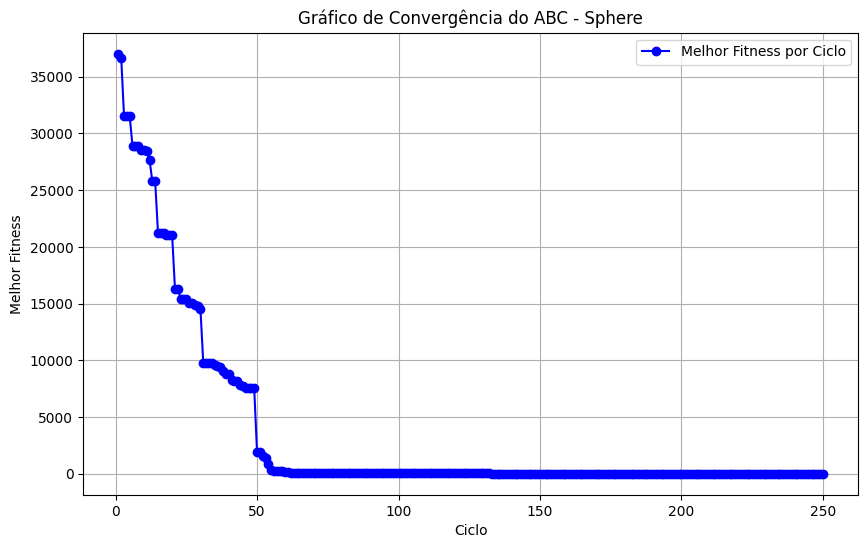

In [28]:
alg = AlgoritmoABC(dimensoes=20,
                   limite_min=-100.0,
                   limite_max=100.0,
                   tamanho_populacao=100,
                   fator_abandono=20,
                   ciclos=250,
                   funcao_fitness=sphere)

historico_fitness = alg.executar()
alg.exibir_melhor_fitness()
alg.plotar_grafico_convergencia(historico_fitness=historico_fitness,funcao_fitness="Sphere")


### Execução do ABC - Rastrigin

Ciclo 5306 - Melhor Fitness: 0.02322139873716189 - Melhor Posição: [ 0.00151578 -0.03307905 -0.00108208 -0.00318697 -0.01442566  0.03011347
  0.04577136  0.0431794   0.0605811  -0.00544744 -0.00264047  0.05011702
 -0.00275189 -0.06449265  0.01013828 -0.02011616 -0.02217471 -0.00967826
  0.03415337  0.05547569]


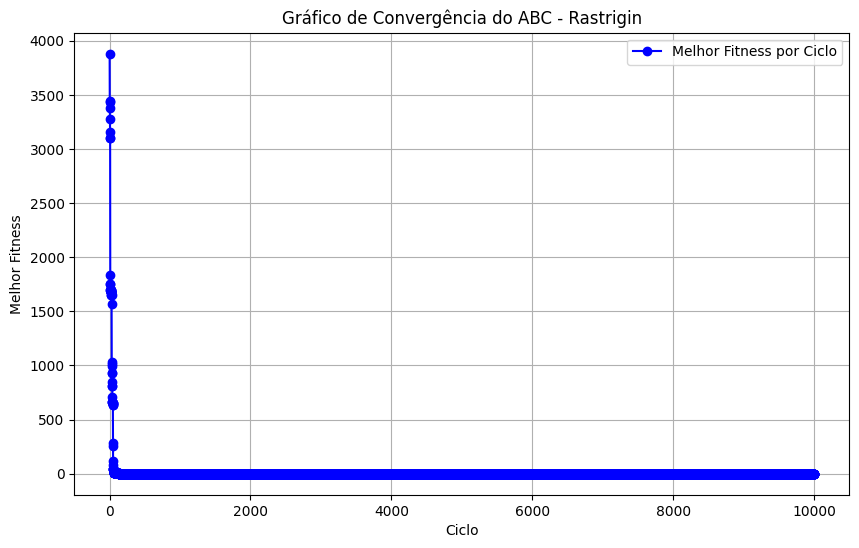

In [9]:
alg = AlgoritmoABC(dimensoes=20,
                   limite_min=-30.0,
                   limite_max=30.0,
                   tamanho_populacao=50,
                   fator_abandono=20,
                   ciclos=10000,
                   funcao_fitness=rastrigin)

historico_fitness = alg.executar()
alg.exibir_melhor_fitness()
alg.plotar_grafico_convergencia(historico_fitness=historico_fitness,funcao_fitness="Rastrigin")


### Execução do ABC - Rosenbrock

Ciclo 80 - Melhor Fitness: 7906.9463670456935 - Melhor Posição: [ 0.48013816  0.53963654  1.34085348 -2.32761835  0.91092774 -0.44068182
  1.42482819  1.33467304  0.14246112  0.89814047  0.19953217  0.54341658
 -0.81829083  0.74551985 -1.36750316  0.92875408  0.10746404 -2.36776574
  1.12728031  0.67283926]


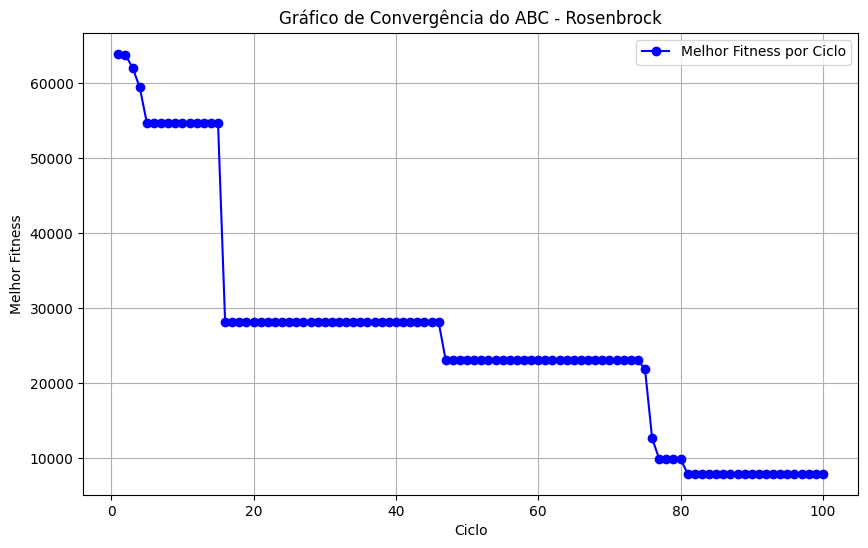

In [18]:
alg = AlgoritmoABC(dimensoes=20,
                   limite_min=-5.12,
                   limite_max=5.12,
                   tamanho_populacao=50,
                   fator_abandono=5,
                   ciclos=100,
                   funcao_fitness=rosenbrock)

historico_fitness = alg.executar()
alg.exibir_melhor_fitness()
alg.plotar_grafico_convergencia(historico_fitness=historico_fitness,funcao_fitness="Rosenbrock")


### Boxplot com Função fitness: Sphere

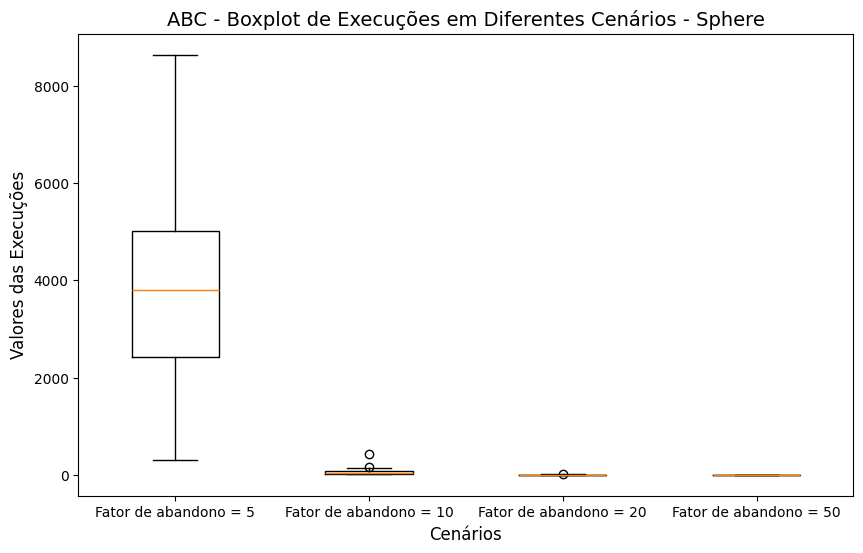

In [11]:
cenario_1 = []
for _ in range(30):
    alg = AlgoritmoABC(dimensoes=20, limite_min=-100.0, limite_max=100.0, tamanho_populacao=100,fator_abandono=5   , 
                       ciclos=250, funcao_fitness=sphere)
    alg.executar()
    cenario_1.append(alg.melhor_fitness)

cenario_2 = []
for _ in range(30):
    alg = AlgoritmoABC(dimensoes=20, limite_min=-100.0, limite_max=100.0, tamanho_populacao=100,fator_abandono=10, 
                       ciclos=250, funcao_fitness=sphere)
    alg.executar()
    cenario_2.append(alg.melhor_fitness)

cenario_3 = []
for _ in range(30):
    alg = AlgoritmoABC(dimensoes=20, limite_min=-100.0, limite_max=100.0, tamanho_populacao=100,fator_abandono=20, 
                       ciclos=250, funcao_fitness=sphere)
    alg.executar()
    cenario_3.append(alg.melhor_fitness)

cenario_4 = []
for _ in range(30):
    alg = AlgoritmoABC(dimensoes=20, limite_min=-100.0, limite_max=100.0, tamanho_populacao=100,fator_abandono=50, 
                       ciclos=250, funcao_fitness=sphere)
    alg.executar()
    cenario_4.append(alg.melhor_fitness)

dados = [cenario_1, cenario_2, cenario_3, cenario_4]

plt.figure(figsize=(10, 6))
plt.boxplot(dados, labels=['Fator de abandono = 5', 'Fator de abandono = 10', 'Fator de abandono = 20', 'Fator de abandono = 50'])

plt.title('ABC - Boxplot de Execuções em Diferentes Cenários - Sphere', fontsize=14)
plt.xlabel('Cenários', fontsize=12)
plt.ylabel('Valores das Execuções', fontsize=12)

plt.show()

### Boxplot com Função fitness: Rastrigin

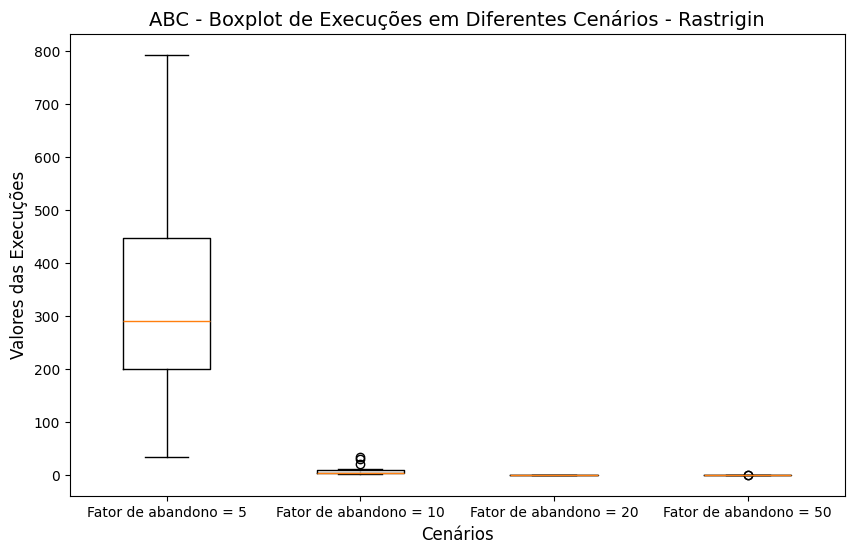

In [31]:
cenario_1 = []
for _ in range(30):
    alg = AlgoritmoABC(dimensoes=20, limite_min=-30.0, limite_max=30.0, tamanho_populacao=100,fator_abandono=5   , 
                       ciclos=250, funcao_fitness=rastrigin)
    alg.executar()
    cenario_1.append(alg.melhor_fitness)

cenario_2 = []
for _ in range(30):
    alg = AlgoritmoABC(dimensoes=20, limite_min=-30.0, limite_max=30.0, tamanho_populacao=100,fator_abandono=10, 
                       ciclos=250, funcao_fitness=rastrigin)
    alg.executar()
    cenario_2.append(alg.melhor_fitness)

cenario_3 = []
for _ in range(30):
    alg = AlgoritmoABC(dimensoes=20, limite_min=-30.0, limite_max=30.0, tamanho_populacao=100,fator_abandono=20, 
                       ciclos=250, funcao_fitness=rastrigin)
    alg.executar()
    cenario_3.append(alg.melhor_fitness)

cenario_4 = []
for _ in range(30):
    alg = AlgoritmoABC(dimensoes=20, limite_min=-30.0, limite_max=30.0, tamanho_populacao=100,fator_abandono=50, 
                       ciclos=250, funcao_fitness=rastrigin)
    alg.executar()
    cenario_4.append(alg.melhor_fitness)

dados = [cenario_1, cenario_2, cenario_3, cenario_4]

plt.figure(figsize=(10, 6))
plt.boxplot(dados, tick_labels=['Fator de abandono = 5', 'Fator de abandono = 10', 'Fator de abandono = 20', 'Fator de abandono = 50'])

plt.title('ABC - Boxplot de Execuções em Diferentes Cenários - Rastrigin', fontsize=14)
plt.xlabel('Cenários', fontsize=12)
plt.ylabel('Valores das Execuções', fontsize=12)

plt.show()

### Boxplot com Função fitness: Rosenbrock

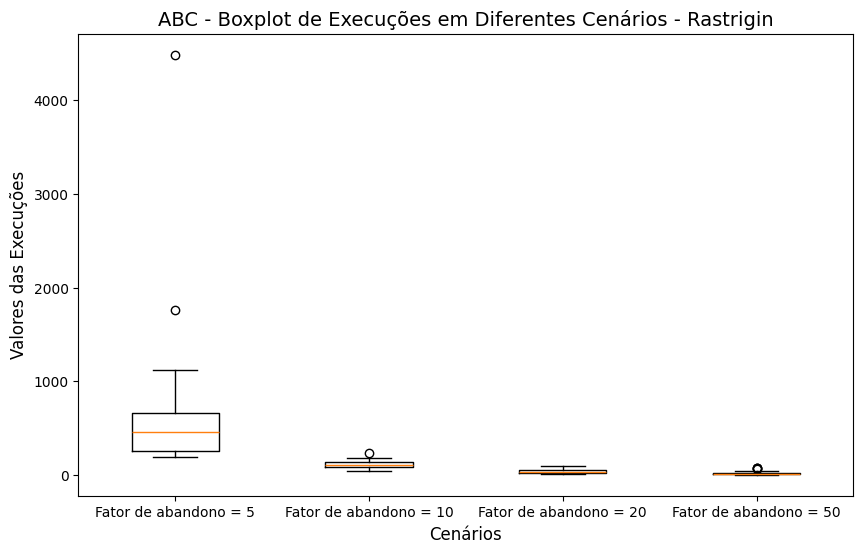

In [12]:
cenario_1 = []
for _ in range(30):
    alg = AlgoritmoABC(dimensoes=20, limite_min=-5.12, limite_max=5.12, tamanho_populacao=100,fator_abandono=5   , 
                       ciclos=250, funcao_fitness=rosenbrock)
    alg.executar()
    cenario_1.append(alg.melhor_fitness)

cenario_2 = []
for _ in range(30):
    alg = AlgoritmoABC(dimensoes=20, limite_min=-5.12, limite_max=5.12, tamanho_populacao=100,fator_abandono=10, 
                       ciclos=250, funcao_fitness=rosenbrock)
    alg.executar()
    cenario_2.append(alg.melhor_fitness)

cenario_3 = []
for _ in range(30):
    alg = AlgoritmoABC(dimensoes=20, limite_min=-5.12, limite_max=5.12, tamanho_populacao=100,fator_abandono=20, 
                       ciclos=250, funcao_fitness=rosenbrock)
    alg.executar()
    cenario_3.append(alg.melhor_fitness)

cenario_4 = []
for _ in range(30):
    alg = AlgoritmoABC(dimensoes=20, limite_min=-5.12, limite_max=5.12, tamanho_populacao=100,fator_abandono=50, 
                       ciclos=250, funcao_fitness=rosenbrock)
    alg.executar()
    cenario_4.append(alg.melhor_fitness)

dados = [cenario_1, cenario_2, cenario_3, cenario_4]

plt.figure(figsize=(10, 6))
plt.boxplot(dados, tick_labels=['Fator de abandono = 5', 'Fator de abandono = 10', 'Fator de abandono = 20', 'Fator de abandono = 50'])

plt.title('ABC - Boxplot de Execuções em Diferentes Cenários - Rastrigin', fontsize=14)
plt.xlabel('Cenários', fontsize=12)
plt.ylabel('Valores das Execuções', fontsize=12)

plt.show()